De vier gevraagde modellen staan hieronder beschreven

    Decision Tree & Random Forest: Maak een model dat de retourreden van teruggebrachte producten voorspelt. Maak hiervan eerst een 'eenvoudige' decision tree en daarna een random forest. 
    Regressie: Maak een model dat het aantal teruggebrachte producten voorspelt. Maak gebruik van een regressiemodel. Start met een lineaire regressie en bekijk of je het model kan verbeteren met een geavanceerder regressietype. 
    Clustering: Maak een clustering van klanten waarbij er voor The Great Outdoors interessante groepen te herkennen zijn. Bepaal zelf hoe je het aantal clusters bepaalt en controleer in hoeverre deze clustering overeenkomt met data uit de kolom "RETAILER_TYPE".
    Frequent Itemset: Bekijk welke soorten producten vaak samen worden verkocht. Maak hierbij gemotiveerde keuzes ten aanzien van support en lift.


## Decision Tree & Random Forest

Import necessary modules.

In [14]:
import pyodbc
import pandas as pd
import numpy as np
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures,StandardScaler
from sklearn.pipeline import make_pipeline
from scipy.interpolate import UnivariateSpline
from sklearn.ensemble import AdaBoostClassifier

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

In [15]:


# Connect to the Access database and load the data
connectionString = (
    r'Driver={Microsoft Access Driver (*.mdb, *.accdb)};'
    r'DBQ=./go_sales_schoon.accdb;'
)
db = pyodbc.connect(connectionString)

returned_items_query = 'SELECT RETURN_REASON_CODE, RETURN_QUANTITY, ORDER_DETAIL_CODE FROM returned_item'
order_details_query = 'SELECT * FROM order_details'
return_reason_query = 'SELECT RETURN_REASON_CODE, RETURN_DESCRIPTION_EN FROM return_reason'
product_query = 'SELECT PRODUCT_NUMBER, PRODUCT_TYPE_CODE FROM product'
product_type_query = 'SELECT PRODUCT_TYPE_CODE, PRODUCT_LINE_CODE FROM product_type'
product_line_query = 'SELECT PRODUCT_LINE_CODE, PRODUCT_LINE_EN FROM product_line'
order_header_query = 'SELECT ORDER_NUMBER, RETAILER_NAME, RETAILER_SITE_CODE FROM order_header'
sales_retailer_site_query = 'SELECT RETAILER_SITE_CODE, COUNTRY_CODE FROM sales_retailer_site'
sales_country_query = 'SELECT COUNTRY_CODE, COUNTRY FROM sales_country'

# Read tables
returned_items = pd.read_sql(returned_items_query, db)
order_details = pd.read_sql(order_details_query, db)
return_reasons = pd.read_sql(return_reason_query, db)
product = pd.read_sql(product_query, db)
product_type = pd.read_sql(product_type_query, db)
product_line = pd.read_sql(product_line_query, db)
order_header = pd.read_sql(order_header_query, db)
sales_retailer_site = pd.read_sql(sales_retailer_site_query, db)
sales_country = pd.read_sql(sales_country_query, db)

data = pd.merge(returned_items, order_details, on="ORDER_DETAIL_CODE")
data = pd.merge(data, return_reasons, on="RETURN_REASON_CODE")

data = data[['RETURN_DESCRIPTION_EN', 'RETURN_QUANTITY', 'PRODUCT_NUMBER']]

C:\Users\manny\AppData\Local\Temp\ipykernel_25280\2138650501.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  returned_items = pd.read_sql(returned_items_query, db)
C:\Users\manny\AppData\Local\Temp\ipykernel_25280\2138650501.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  order_details = pd.read_sql(order_details_query, db)
C:\Users\manny\AppData\Local\Temp\ipykernel_25280\2138650501.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return_reasons = pd.read_sql(return_reason_query, db)
C:\Users\manny\AppData\Lo

Confusion Matrix Generator

In [16]:
def print_confusion_matrix(y_true, y_pred, labels):
    # Calculate confusion matrix
    conf_mat = metrics.confusion_matrix(y_true, y_pred, labels=labels)
    # Plot confusion matrix
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=labels)
    fig, ax = plt.subplots(figsize=(20, 20))
    disp.plot(ax=ax, cmap=plt.cm.Blues)
    plt.show()

Tree Generator

In [17]:
from typing import Sequence


def print_best_tree(randomForestClassifier: RandomForestClassifier, featureNames: Sequence[str], classNames: Sequence[any], figureSize = (15, 15)):
    # Visualize the best tree
    best_tree = randomForestClassifier.estimators_[0]
    _, ax = plt.subplots(figsize=figureSize)
    plot_tree(best_tree, ax=ax, feature_names=featureNames, class_names=classNames, filled=True)
    plt.show()

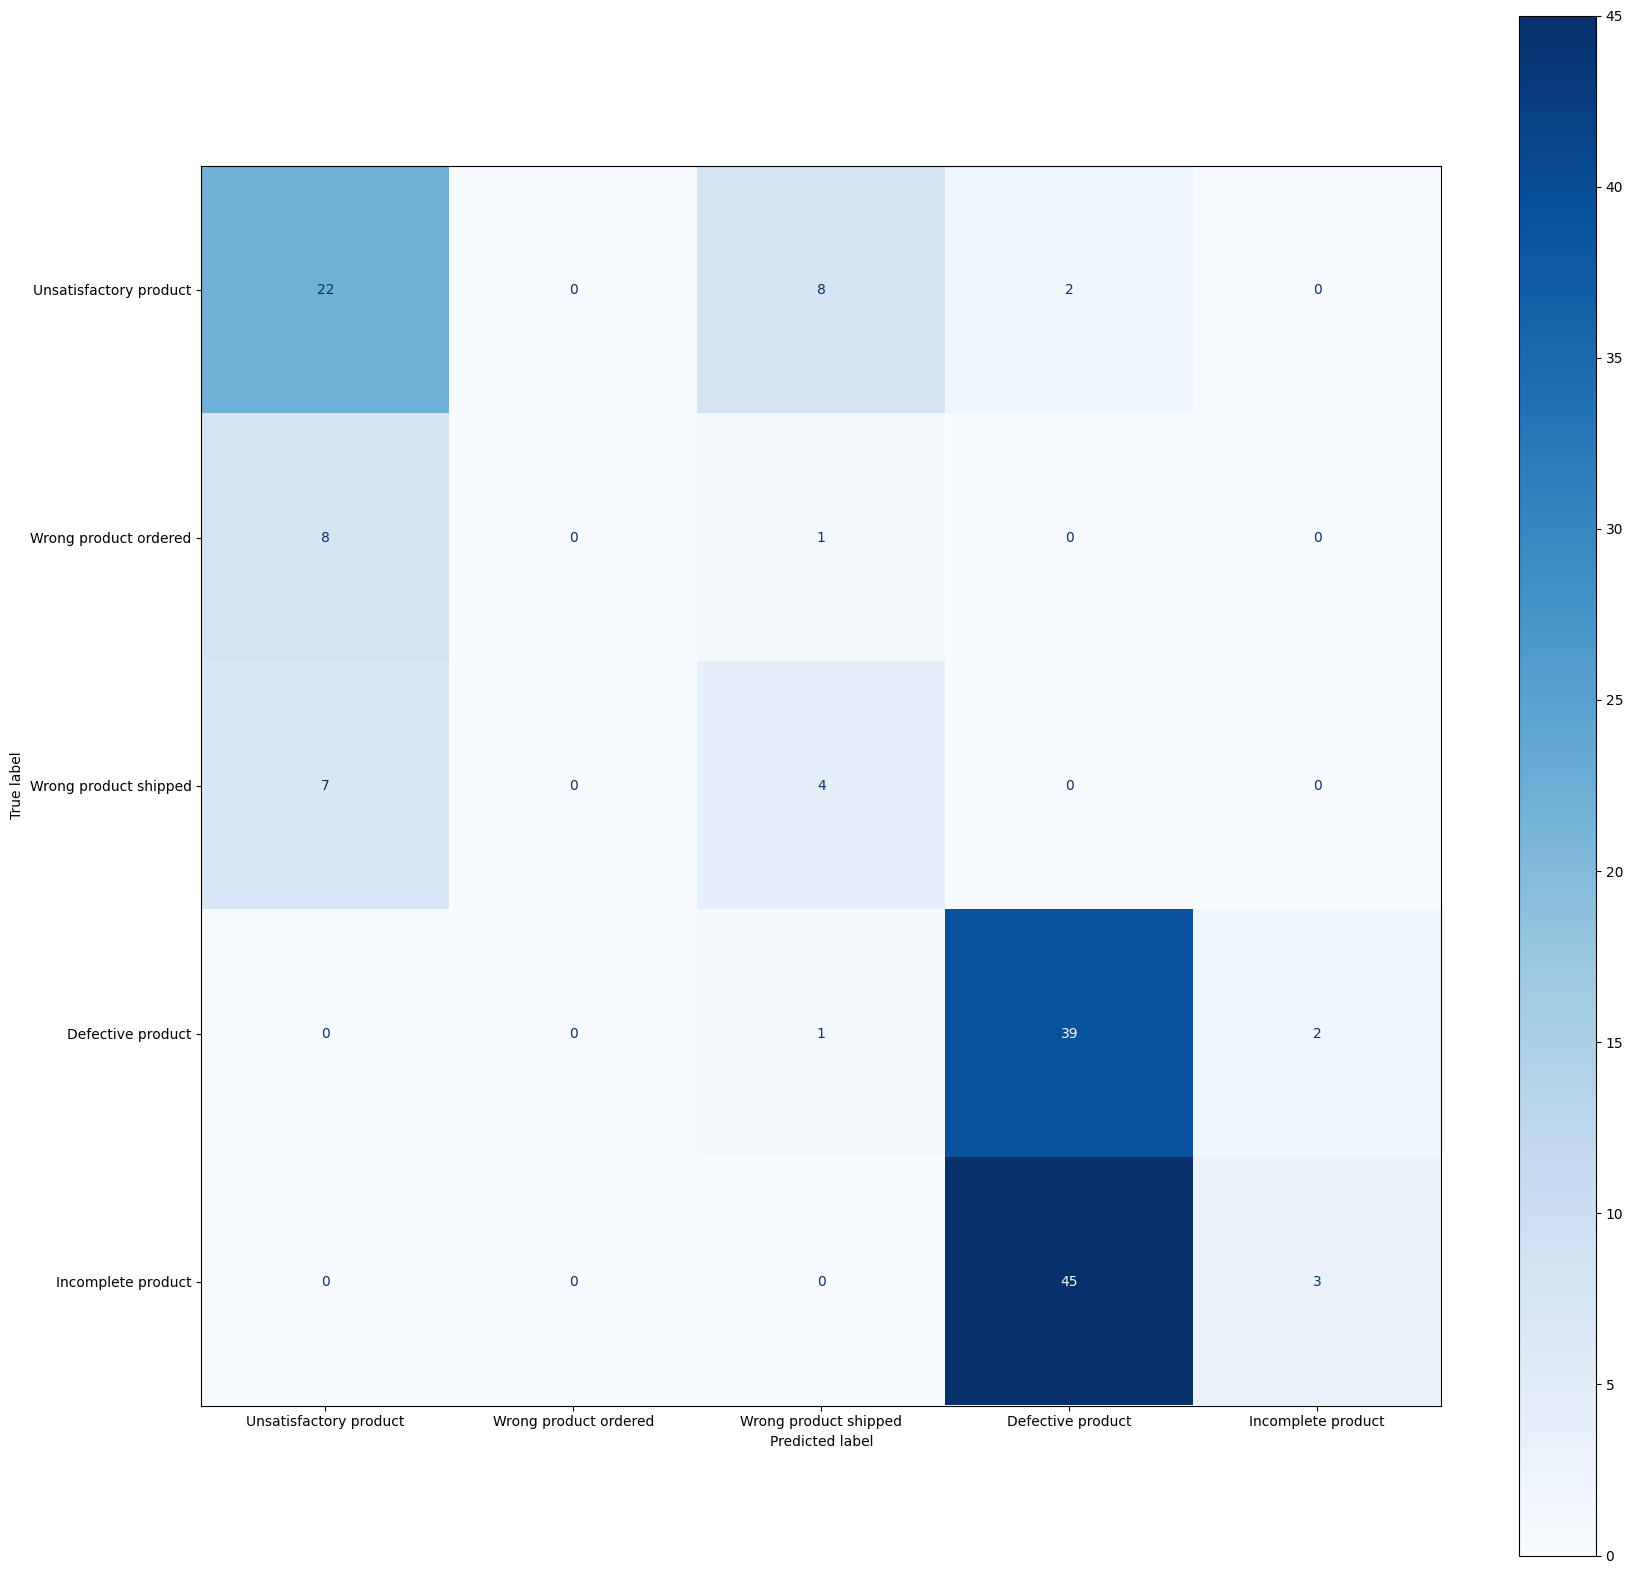

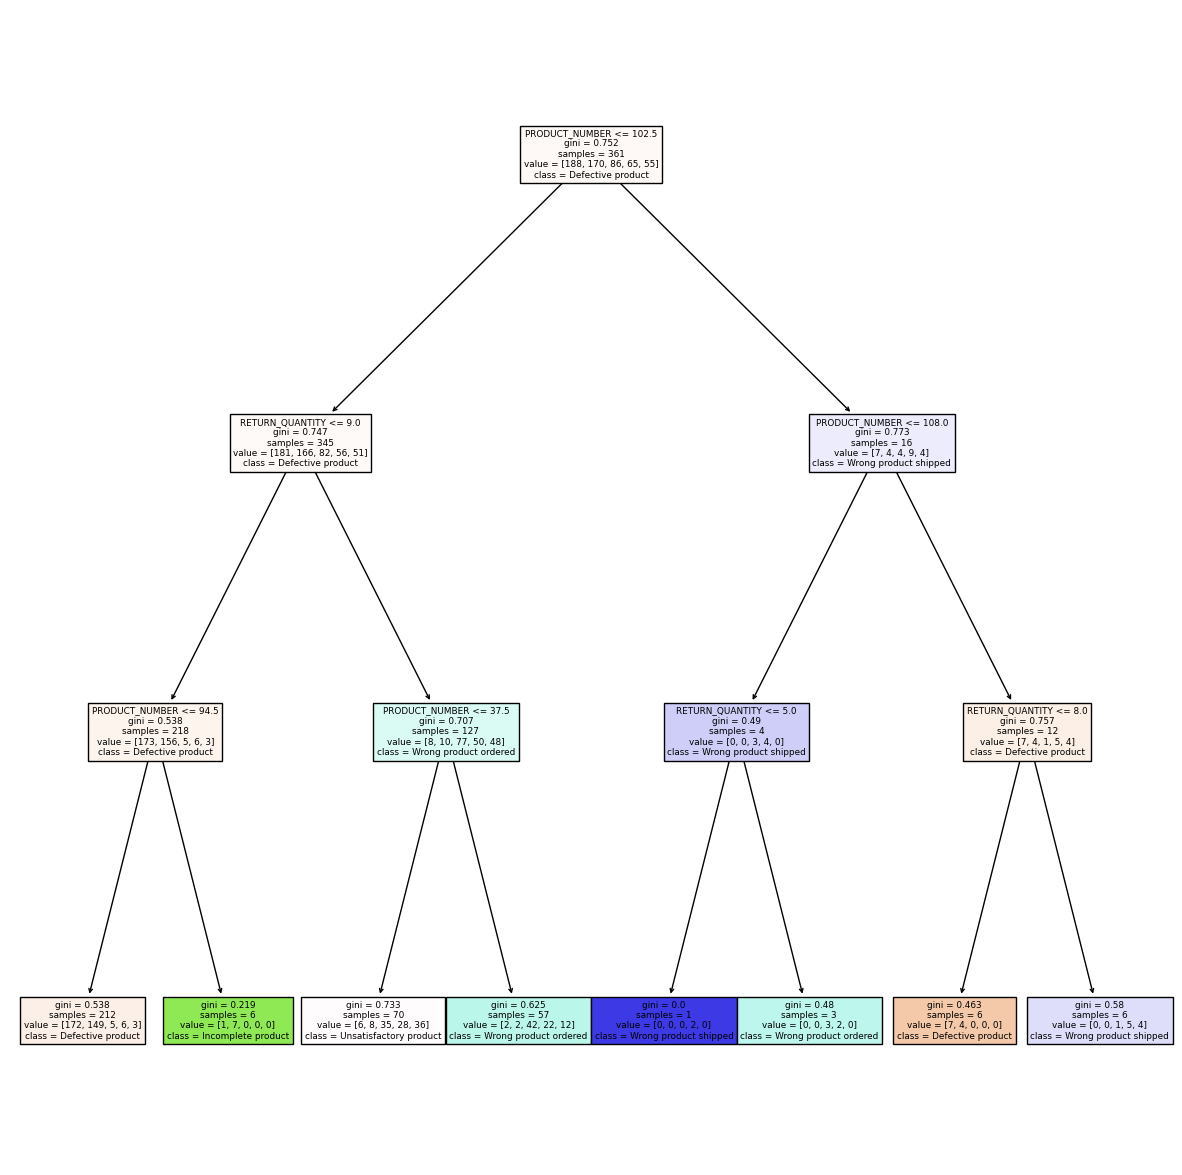

In [18]:

X = data.drop('RETURN_DESCRIPTION_EN', axis=1)
y = data['RETURN_DESCRIPTION_EN']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest model
randomForestClassifier = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42)
randomForestClassifier.fit(X_train, y_train)

# Evaluate the model
y_pred = randomForestClassifier.predict(X_test)
 # Create labels for better readability
labels = list(set(y_test))

print_confusion_matrix(y_test, y_pred, labels)

# Visualize the best tree
print_best_tree(randomForestClassifier, ['RETURN_QUANTITY', 'PRODUCT_NUMBER'], return_reasons['RETURN_DESCRIPTION_EN'].values)
first_model = randomForestClassifier

In [19]:
# Merge the data
data = pd.merge(returned_items, order_details, on="ORDER_DETAIL_CODE")
data = pd.merge(data, product, on="PRODUCT_NUMBER")
data = pd.merge(data, product_type, on = "PRODUCT_TYPE_CODE")
data = pd.merge(data, product_line, on="PRODUCT_LINE_CODE")
data = pd.merge(data, order_header, on="ORDER_NUMBER")
data = pd.merge(data, sales_retailer_site, on="RETAILER_SITE_CODE")
data = pd.merge(data, sales_country, on="COUNTRY_CODE")
data = pd.merge(data, return_reasons, on="RETURN_REASON_CODE")

# Preprocess the data
data = data[['RETURN_DESCRIPTION_EN', 'RETURN_QUANTITY', 'PRODUCT_LINE_EN']]

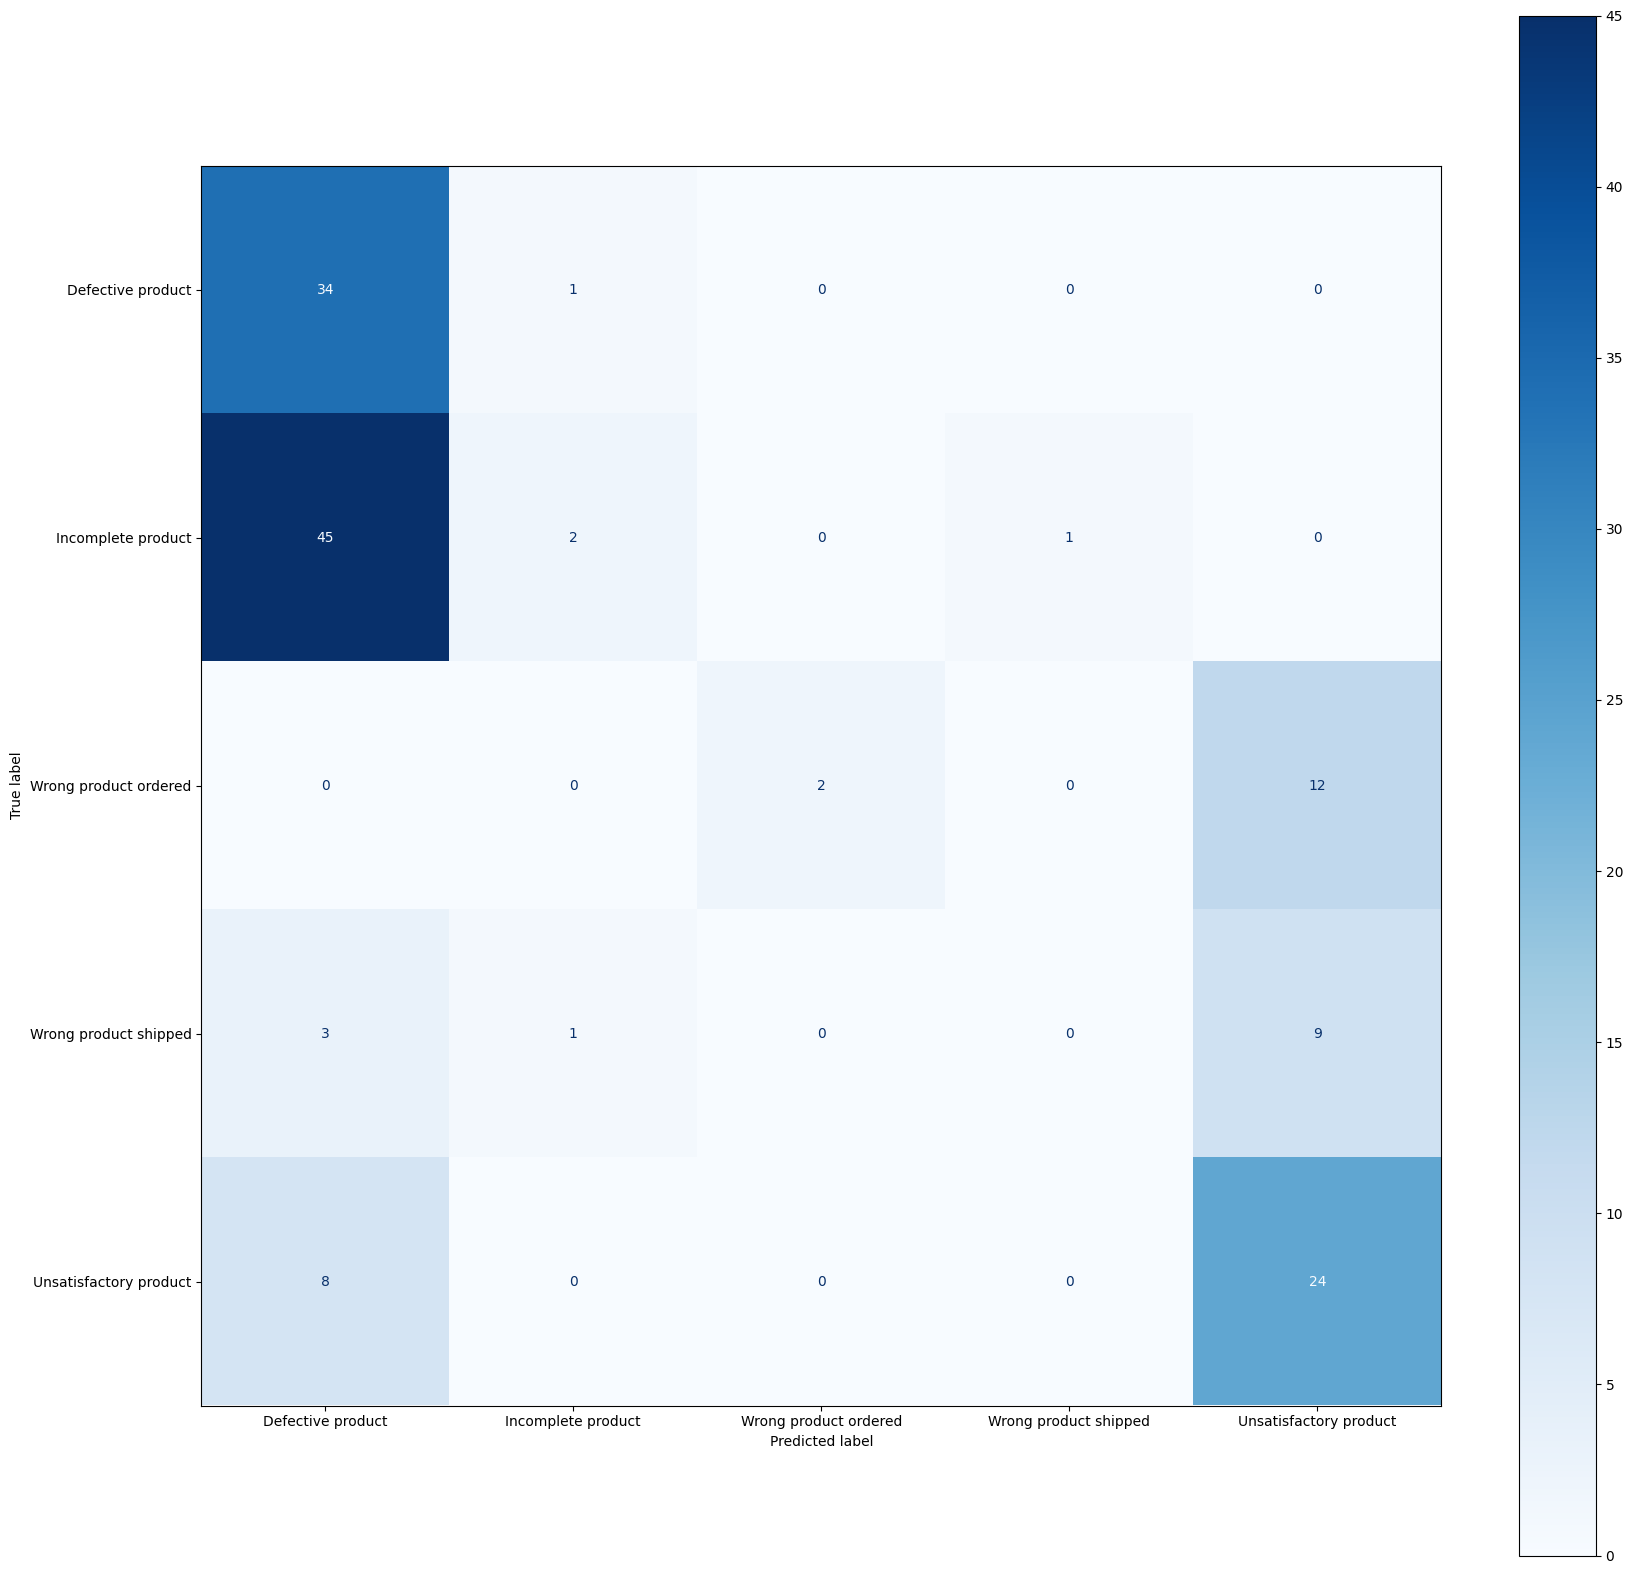

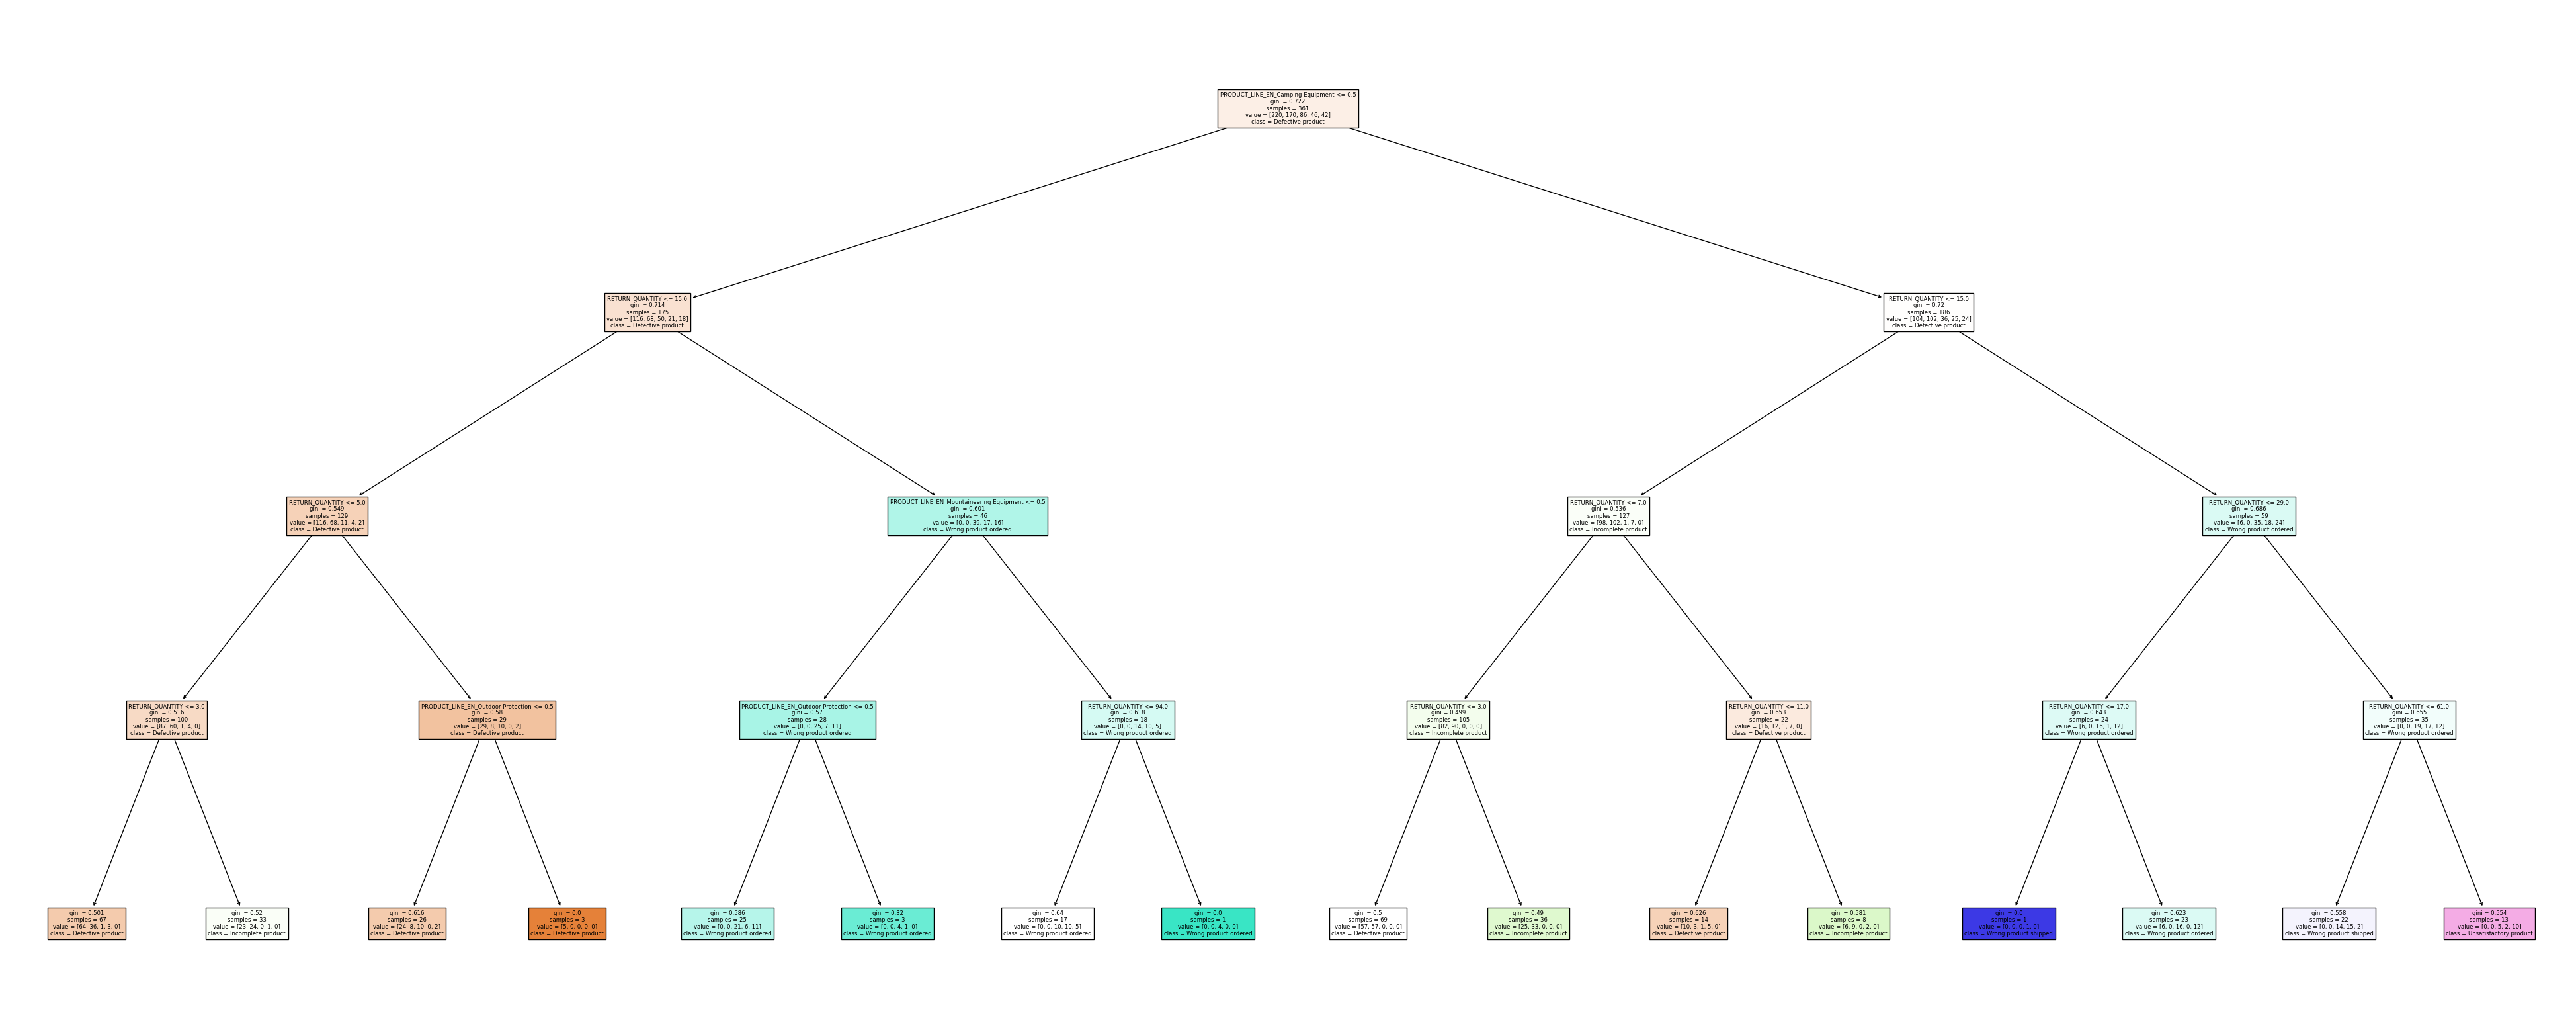

In [20]:


X = data.drop('RETURN_DESCRIPTION_EN', axis=1)
y = data['RETURN_DESCRIPTION_EN']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# One-hot encoding for categorical features
X_train = pd.get_dummies(X_train, columns=['PRODUCT_LINE_EN'])
X_test = pd.get_dummies(X_test, columns=['PRODUCT_LINE_EN'])

# Ensure both train and test datasets have the same columns after one-hot encoding
X_train, X_test = X_train.align(X_test, join='left', axis=1)
X_test = X_test.fillna(0)

# Train the Random Forest model
rfc = RandomForestClassifier(n_estimators=300, max_depth=4, random_state=42)

# Train the Random Forest model on the full dataset
rfc.fit(X_train, y_train)

# Evaluate
y_pred = rfc.predict(X_test)
labels = return_reasons['RETURN_DESCRIPTION_EN'].unique()
print_confusion_matrix(y_test, y_pred, labels)

second_model = rfc

print_best_tree(rfc, X_train.columns, return_reasons['RETURN_DESCRIPTION_EN'].values, (50, 20))


c:\Users\manny\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


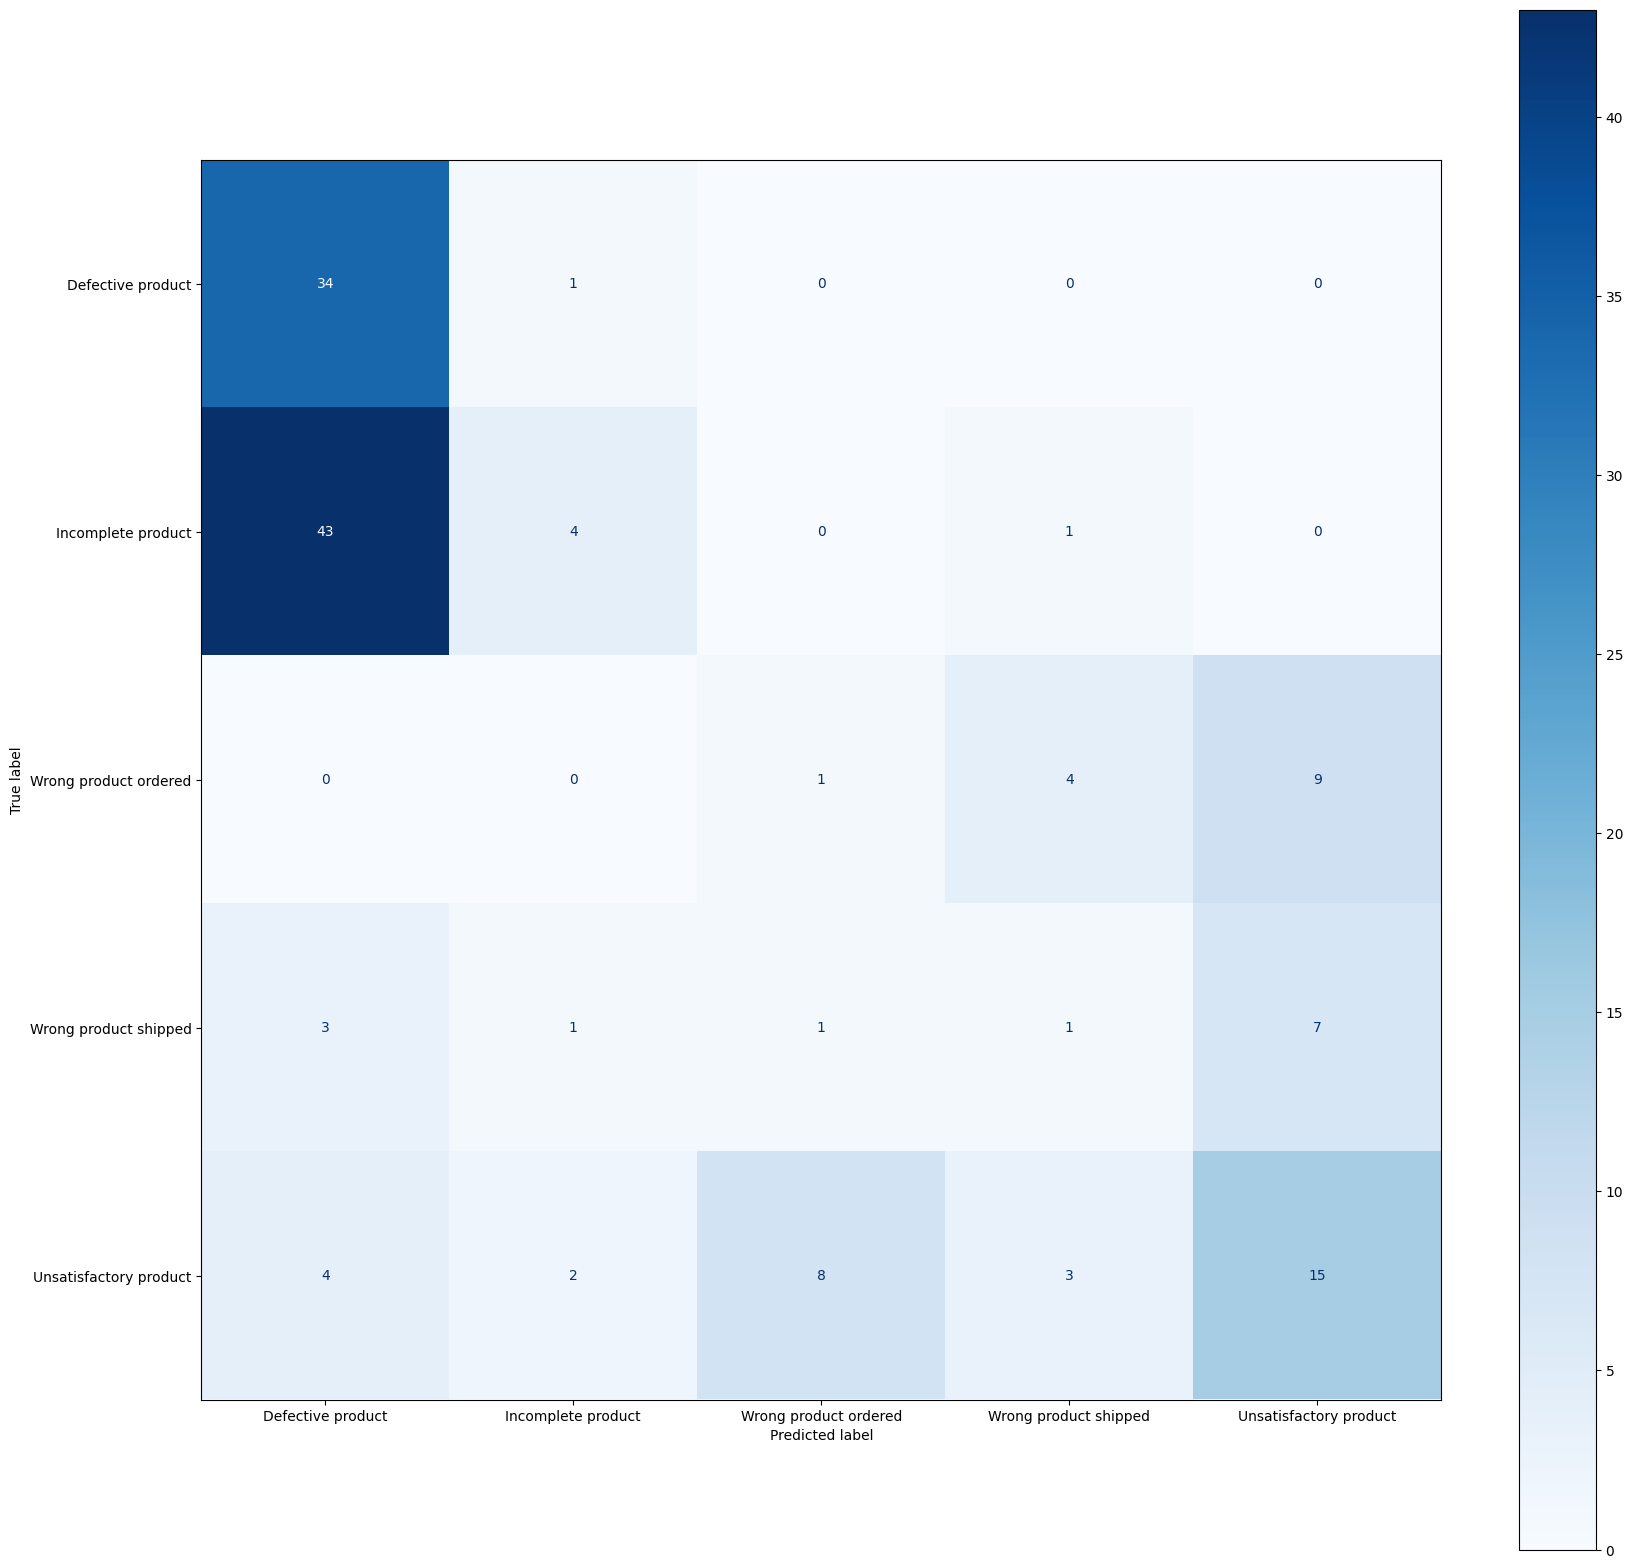

In [21]:
# Merge the data
data = pd.merge(returned_items, order_details, on="ORDER_DETAIL_CODE")
data = pd.merge(data, return_reasons, on="RETURN_REASON_CODE")

# Preprocess the data for model one
data_model_one = data[['RETURN_REASON_CODE', 'RETURN_QUANTITY', 'PRODUCT_NUMBER']]
X_model_one = data_model_one.drop('RETURN_REASON_CODE', axis=1)
y_model_one = data_model_one['RETURN_REASON_CODE']

# Train-test split for model one
X_train_one, X_test_one, y_train_one, y_test_one = train_test_split(X_model_one, y_model_one, test_size=0.2, random_state=42)

# Train the Random Forest model one
rfc_one = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42)
rfc_one.fit(X_train_one, y_train_one)

# Preprocess the data for model two
data_model_two = pd.merge(returned_items, order_details, on="ORDER_DETAIL_CODE")
data_model_two = pd.merge(data_model_two, product, on="PRODUCT_NUMBER")
data_model_two = pd.merge(data_model_two, product_type, on = "PRODUCT_TYPE_CODE")
data_model_two = pd.merge(data_model_two, product_line, on="PRODUCT_LINE_CODE")
data_model_two = pd.merge(data_model_two, order_header, on="ORDER_NUMBER")
data_model_two = pd.merge(data_model_two, sales_retailer_site, on="RETAILER_SITE_CODE")
data_model_two = pd.merge(data_model_two, sales_country, on="COUNTRY_CODE")
data_model_two = pd.merge(data_model_two, return_reasons, on="RETURN_REASON_CODE")

data_model_two = data_model_two[['RETURN_REASON_CODE', 'RETURN_QUANTITY', 'PRODUCT_LINE_EN']]
X_model_two = data_model_two.drop('RETURN_REASON_CODE', axis=1)
y_model_two = data_model_two['RETURN_REASON_CODE']

# One-hot encoding for categorical features in model two
X_model_two = pd.get_dummies(X_model_two, columns=['PRODUCT_LINE_EN'])

# Train-test split for model two
X_train_two, X_test_two, y_train_two, y_test_two = train_test_split(X_model_two, y_model_two, test_size=0.2, random_state=42)

# Ensure both train and test datasets have the same columns after one-hot encoding
X_train_two, X_test_two = X_train_two.align(X_test_two, join='left', axis=1)
X_test_two = X_test_two.fillna(0)

# Train the Random Forest model two
rfc_two = RandomForestClassifier(n_estimators=300, max_depth=5, random_state=42)
rfc_two.fit(X_train_two, y_train_two)

boost_model = AdaBoostClassifier(base_estimator=rfc_one, n_estimators=50, random_state=42)
# Train the Random Subspace Method classifier on the full dataset
boost_model.fit(X_train, y_train)


# Evaluate the Random Subspace Method classifier
y_pred = boost_model.predict(X_test)
labels = return_reasons['RETURN_DESCRIPTION_EN'].unique()
print_confusion_matrix(y_test, y_pred, labels)



# Regression Model

In [22]:
def print_quality_metrics(mse, rss, r2):
    print(f"Significance (degree of randomness): {mse/rss}")
    print(f"Correlation coefficient (R-squared value) = {r2}")
    print(f"RSS (Residual sum of squares): {rss}")


In [23]:
# Query the database and retrieve the relevant data
query1 = """
SELECT RETURN_QUANTITY, RETURN_REASON_CODE, ORDER_DETAIL_CODE
FROM returned_item
"""
returned_item_df = pd.read_sql(query1, db)

query2 = """
SELECT ORDER_DETAIL_CODE, PRODUCT_NUMBER, UNIT_SALE_PRICE, ORDER_NUMBER, QUANTITY
FROM order_details
"""
order_details_df = pd.read_sql(query2, db)

query3 = """
SELECT ORDER_NUMBER, RETAILER_SITE_CODE
FROM order_header
"""
order_header_df = pd.read_sql(query3, db)

# Merge the dataframes on their common columns
merged_df = pd.merge(returned_item_df, order_details_df, on='ORDER_DETAIL_CODE')
merged_df = pd.merge(merged_df, order_header_df, on='ORDER_NUMBER')
merged_df['RETURN_QUANTITY'] = merged_df['RETURN_QUANTITY'].astype(float)

# Split the data into features and target
X = merged_df[['QUANTITY']]
y = merged_df['RETURN_QUANTITY']

# Fit a linear regression model
model = LinearRegression()
model.fit(X, y)

new_product_number= 96
ordered_qunaitity = 15
new_return_quantity = model.predict([[ new_product_number]])
print(f"Predicted return quantity for product number {new_product_number},  and ordered quantity {ordered_qunaitity}: {new_return_quantity}")

# Calculate the model's quality metrics
y_pred = model.predict(X)
rss = np.sum((y - y_pred) ** 2)
tss = np.sum((y - np.mean(y)) ** 2)
mse = metrics.mean_squared_error(y, y_pred)
r2 = metrics.r2_score(y, y_pred)

print_quality_metrics(mse, rss, r2)

C:\Users\manny\AppData\Local\Temp\ipykernel_25280\2989301483.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  returned_item_df = pd.read_sql(query1, db)
C:\Users\manny\AppData\Local\Temp\ipykernel_25280\2989301483.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  order_details_df = pd.read_sql(query2, db)


Predicted return quantity for product number 96,  and ordered quantity 15: [35.16942595]
Significance (degree of randomness): 0.00141643059490085
Correlation coefficient (R-squared value) = 0.2482189839243577
RSS (Residual sum of squares): 801942.0986815662


C:\Users\manny\AppData\Local\Temp\ipykernel_25280\2989301483.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  order_header_df = pd.read_sql(query3, db)
c:\Users\manny\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [24]:
# Fit a spline regression model
model = make_pipeline(PolynomialFeatures(3), LinearRegression())
model.fit(X, y)
xs = np.linspace(X.min(), X.max(), 100)
ys = model.predict(xs.reshape(-1, 1))
spline = UnivariateSpline(xs, ys)
# Make a prediction for a new return based on the quantity ordered
new_quantity_ordered = 15
new_return_quantity = spline(new_quantity_ordered)
print(f"Predicted return quantity for ordered quantity {new_quantity_ordered}: {new_return_quantity}")

# Calculate the model's quality metrics
y_pred = model.predict(X)
rss = np.sum((y - y_pred) ** 2)
tss = np.sum((y - np.mean(y)) ** 2)
mse = metrics.mean_squared_error(y, y_pred)
r2 = metrics.r2_score(y, y_pred)

print_quality_metrics(mse, rss, r2)

Predicted return quantity for ordered quantity 15: 5.554286731747014
Significance (degree of randomness): 0.00141643059490085
Correlation coefficient (R-squared value) = 0.3346375534237437
RSS (Residual sum of squares): 709757.4232142845


c:\Users\manny\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


In [25]:
# Fit a quadratic regression model
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)
model = LinearRegression()
model.fit(X_poly, y)

# Make a prediction for a new return based on the ordered quantity
new_ordered_quantity = 15
new_return_quantity = model.predict(poly.transform([[new_ordered_quantity]]))
# Calculate the model's quality metrics
y_pred = model.predict(X_poly)
rss = np.sum((y - y_pred) ** 2)
tss = np.sum((y - np.mean(y)) ** 2)
mse = metrics.mean_squared_error(y, y_pred)
r2 = metrics.r2_score(y, y_pred)

print(f"Predicted return quantity for ordered quantity: {new_ordered_quantity}: {new_return_quantity[0]}")

print_quality_metrics(mse, rss, r2)

Predicted return quantity for ordered quantity: 15: 11.7121254286719
Significance (degree of randomness): 0.00141643059490085
Correlation coefficient (R-squared value) = 0.2982182123325805
RSS (Residual sum of squares): 748606.7718979024


c:\Users\manny\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


## Cluster

C:\Users\manny\AppData\Local\Temp\ipykernel_25280\166597129.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  age_group = pd.read_sql("SELECT * FROM age_group", db)
C:\Users\manny\AppData\Local\Temp\ipykernel_25280\166597129.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  retailer = pd.read_sql("SELECT * FROM retailer", db)
C:\Users\manny\AppData\Local\Temp\ipykernel_25280\166597129.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  retailer_type = pd.read_sql("SELECT * FROM retailer_type", db)
C:\Users\manny\AppDa

 sillhouette_score is 0.6507103767662225


c:\Users\manny\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


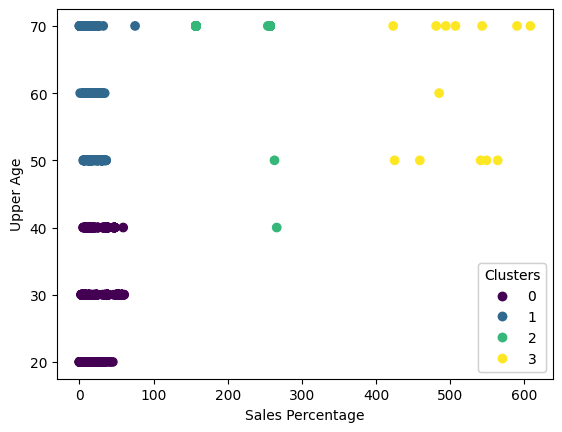

RETAILER_TYPE_EN  Department Store  Direct Marketing  Equipment Rental Store  \
Cluster                                                                        
0                            137.0             189.0                   201.0   
1                            108.0             143.0                   147.0   
2                              7.0              10.0                    12.0   
3                              3.0               NaN                     NaN   

RETAILER_TYPE_EN  Eyewear Store  Golf Shop  Outdoors Shop  Sports Store  \
Cluster                                                                   
0                         111.0      144.0          190.0         100.0   
1                          82.0      117.0          148.0          81.0   
2                           6.0        6.0            9.0           4.0   
3                           1.0        2.0            2.0           2.0   

RETAILER_TYPE_EN  Warehouse Store  
Cluster                         

In [26]:
# Connect to the Access database
conn_str = (
    r'Driver={Microsoft Access Driver (*.mdb, *.accdb)};'
    r'DBQ=./go_crm_schoon.accdb;'
)
db = pyodbc.connect(conn_str)

# Read tables into pandas DataFrames
age_group = pd.read_sql("SELECT * FROM age_group", db)
retailer = pd.read_sql("SELECT * FROM retailer", db)
retailer_type = pd.read_sql("SELECT * FROM retailer_type", db)
sales_demographic = pd.read_sql("SELECT * FROM sales_demographic", db)

# Join the tables
merged_df = sales_demographic.merge(retailer, on='RETAILER_CODEMR')
merged_df = merged_df.merge(age_group, on='AGE_GROUP_CODE')
merged_df = merged_df.merge(retailer_type, on='RETAILER_TYPE_CODE')


# Preprocess data and select features
merged_df['SALES_PERCENT'] = pd.to_numeric(merged_df['SALES_PERCENT'], errors='coerce')
merged_df['SALES_PERCENT'].fillna(merged_df['SALES_PERCENT'].mean(), inplace=True)
merged_df['UPPER_AGE'] = merged_df['UPPER_AGE'].fillna(merged_df['UPPER_AGE'].mean())
features = merged_df[['SALES_PERCENT', 'UPPER_AGE']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)



# Perform clustering using the K-means algorithm
kmeans = KMeans(n_clusters=4, random_state=300)
labels = kmeans.fit_predict(scaled_features)
print(f" sillhouette_score is {metrics.silhouette_score(scaled_features, labels)}")
merged_df['Cluster'] = kmeans.fit_predict(scaled_features)

# Visualize the clusters
scatter = plt.scatter(merged_df['SALES_PERCENT'], merged_df['UPPER_AGE'], c=merged_df['Cluster'], cmap='viridis')
plt.xlabel('Sales Percentage')
plt.ylabel('Upper Age')

# Add a legend to the plot
legend = plt.legend(*scatter.legend_elements(), title='Clusters')
plt.gca().add_artist(legend)

plt.show()

# Investigate the connection between clusters and retailer_type
cluster_retailer_type = merged_df.groupby(['Cluster', 'RETAILER_TYPE_EN']).size().unstack()
print(cluster_retailer_type)

## Frequent Itemset

In [27]:


# Connect to the Access database
conn_str = (
     r'Driver={Microsoft Access Driver (*.mdb, *.accdb)};'
     r'DBQ=./go_sales_schoon.accdb;'
)
db = pyodbc.connect(conn_str)

# Retrieve data from the order_details and product tables
sales = pd.read_sql("SELECT ORDER_NUMBER, PRODUCT_NUMBER FROM order_details", db)
product_names = pd.read_sql("SELECT PRODUCT_NUMBER, PRODUCT_NAME FROM product", db)


# Merge the two dataframes to get the product names for each order
sales_with_names = pd.merge(sales, product_names, on='PRODUCT_NUMBER')
# Convert the dataframe into a list of lists for use with the TransactionEncoder
transaction_list = sales_with_names.groupby('ORDER_NUMBER')['PRODUCT_NAME'].apply(list).values.tolist()

# Encode the transactions as a binary matrix
te = TransactionEncoder()
te_ary = te.fit(transaction_list).transform(transaction_list)

# Convert the binary matrix into a pandas dataframe
df = pd.DataFrame(te_ary, columns=te.columns_)

frequent_itemsets = apriori(df, min_support=0.05, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.5)
frequent_itemsets = frequent_itemsets.sort_values(by='support', ascending=False)

print("Frequently ItemSets:\n")
for index, row in frequent_itemsets.iterrows():
    items = ", ".join(list(row['itemsets']))
    print(f"{items}: {row['support']:.2%}")


C:\Users\manny\AppData\Local\Temp\ipykernel_25280\1783555555.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sales = pd.read_sql("SELECT ORDER_NUMBER, PRODUCT_NUMBER FROM order_details", db)
C:\Users\manny\AppData\Local\Temp\ipykernel_25280\1783555555.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  product_names = pd.read_sql("SELECT PRODUCT_NUMBER, PRODUCT_NAME FROM product", db)


Frequently ItemSets:

Canyon Mule Carryall: 10.69%
Sun Shelter 30: 10.41%
Double Edge: 10.11%
Hibernator Lite: 9.91%
Firefly 2: 9.79%
Glacier GPS Extreme: 9.35%
BugShield Natural: 9.25%
Firefly 4: 8.88%
Hibernator Extreme: 8.73%
Mountain Man Digital: 8.69%
Granite Extreme: 8.66%
TrailChef Water Bag: 8.64%
Star Dome: 8.60%
TrailChef Kettle: 8.58%
TrailChef Kitchen Kit: 8.49%
Hibernator: 8.47%
Granite Axe: 8.47%
Canyon Mule Cooler: 8.41%
Sun Blocker: 8.41%
TrailChef Double Flame: 8.36%
Canyon Mule Extreme Backpack: 8.32%
Star Gazer 3: 8.30%
Hailstorm Steel Woods Set: 8.28%
Bear Edge: 8.26%
TrailChef Utensils: 8.17%
Single Edge: 8.15%
Firefly Extreme: 8.12%
Edge Extreme: 8.12%
Canyon Mule Climber Backpack: 8.12%
Canyon Mule Journey Backpack: 8.08%
Polar Sun: 8.04%
Mountain Man Extreme: 8.00%
Glacier Basic: 7.93%
Granite Grip: 7.91%
Hailstorm Steel Irons: 7.84%
TrailChef Canteen: 7.82%
Hailstorm Titanium Irons: 7.80%
BugShield Lotion Lite: 7.76%
Mountain Man Deluxe: 7.76%
Glacier GPS: 7.76